## Loading and Setup

In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest, chi2, f_classif
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
# Filter warnings
from warnings import filterwarnings
filterwarnings('ignore')

/Users/rachelliao/anaconda3/envs/ensemble/lib/python3.8/site-packages/xgboost/compat.py:93: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [2]:
# Load the dataset
df = pd.read_parquet('dataset/cleaned_data_before_eda.parquet')

## EDA

In [3]:
print(df['loan_status'].unique())

['Fully Paid' 'Current' 'Charged Off' 'In Grace Period'
 'Late (31-120 days)' 'Late (16-30 days)']


In [4]:
# Get the count of each unique value in 'loan_status' column
df['loan_status'].value_counts()

Fully Paid            14838
Charged Off            3711
Current                2285
Late (31-120 days)      116
In Grace Period          53
Late (16-30 days)        12
Name: loan_status, dtype: int64

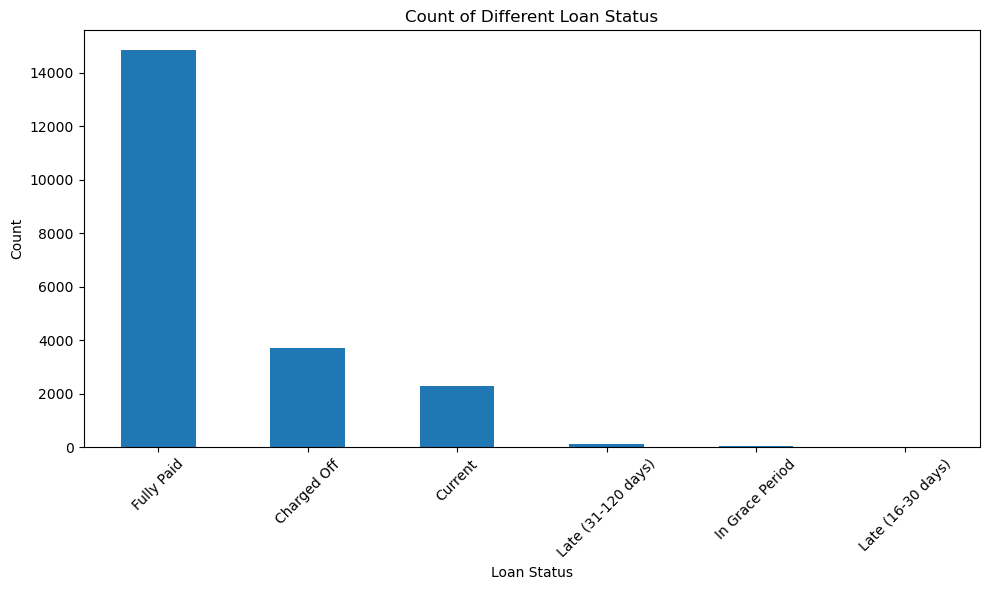

In [5]:
# Create a bar plot for the count of each unique value in 'loan_status' column
plt.figure(figsize=(10, 6))
df['loan_status'].value_counts().plot(kind='bar')
plt.xlabel('Loan Status')
plt.ylabel('Count')
plt.title('Count of Different Loan Status')
plt.xticks(rotation=45)  
plt.tight_layout()  
plt.show()

In [6]:
# Get the percentage of each unique value in 'loan_status' column
df['loan_status'].value_counts() / len(df) * 100

Fully Paid            70.606709
Charged Off           17.658815
Current               10.873186
Late (31-120 days)     0.551987
In Grace Period        0.252201
Late (16-30 days)      0.057102
Name: loan_status, dtype: float64

In [7]:
# Drop the rows with 'Late (16-30 days)', 'Late (31-120 days)', and 'In Grace Period' values in 'loan_status' column
df = df[df['loan_status'] != 'Late (16-30 days)']
df = df[df['loan_status'] != 'Late (31-120 days)']
df = df[df['loan_status'] != 'In Grace Period']

# Check the shape of the dataframe
df.shape

(20834, 106)

In [8]:
# Create a new DataFrame with modified loan_status values
df_modified = df.copy()
df_modified['loan_status'] = df_modified['loan_status'].replace(['Fully Paid', 'Current'], 'Paid')
df_modified['loan_status'] = df_modified['loan_status'].replace(['Charged Off'], 'Default')

# Show the first 5 rows of the modified DataFrame
df_modified.head()

,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,...,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,hardship_flag,disbursement_method,debt_settlement_flag
0,3600.0,3600.0,3600.0,36 months,13.99,123.03,C,C4,leadman,10+ years,...,0.0,0.0,0.0,178050.0,7746.0,2400.0,13734.0,N,Cash,N
1,24700.0,24700.0,24700.0,36 months,11.99,820.28,C,C1,Engineer,10+ years,...,7.7,0.0,0.0,314017.0,39475.0,79300.0,24667.0,N,Cash,N
3,35000.0,35000.0,35000.0,60 months,14.85,829.90,C,C5,Information Systems Officer,10+ years,...,0.0,0.0,0.0,381215.0,52226.0,62500.0,18000.0,N,Cash,N
4,10400.0,10400.0,10400.0,60 months,22.45,289.91,F,F1,Contract Specialist,3 years,...,60.0,0.0,0.0,439570.0,95768.0,20300.0,88097.0,N,Cash,N
5,11950.0,11950.0,11950.0,36 months,13.44,405.18,C,C3,Veterinary Tecnician,4 years,...,100.0,0.0,0.0,16900.0,12798.0,9400.0,4000.0,N,Cash,N


In [9]:
# Get the count of each unique value in 'loan_status' column
df_modified['loan_status'].value_counts()

Paid       17123
Default     3711
Name: loan_status, dtype: int64

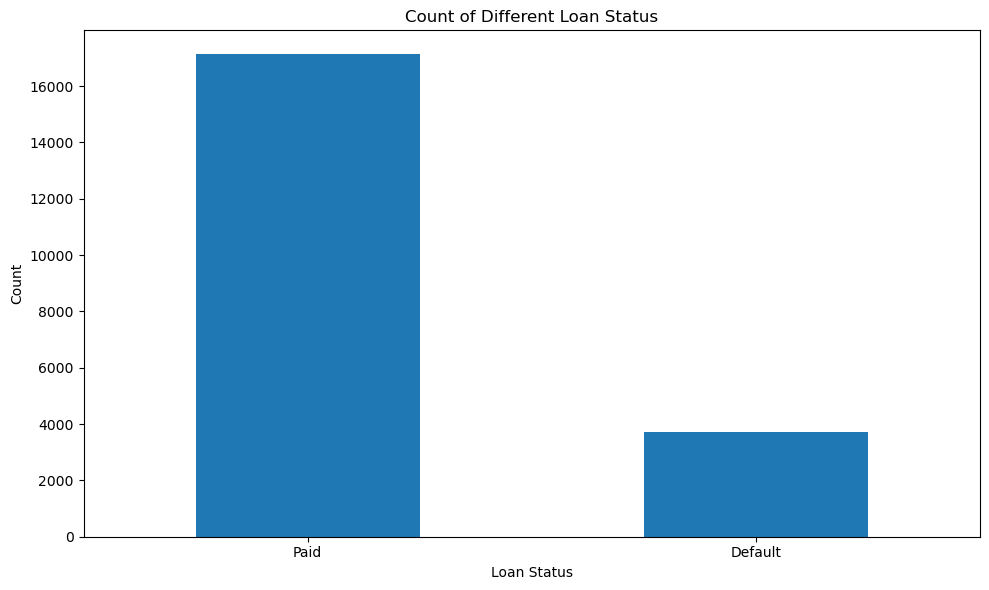

In [10]:
# Create a bar plot for count of values in the modified 'loan_status' column
plt.figure(figsize=(10, 6))
df_modified['loan_status'].value_counts().plot(kind='bar')
plt.xlabel('Loan Status')
plt.ylabel('Count')
plt.title('Count of Different Loan Status')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

In [11]:
# Get the percentage of each unique value in 'loan_status' column
df_modified['loan_status'].value_counts() / len(df_modified) * 100

Paid       82.18777
Default    17.81223
Name: loan_status, dtype: float64

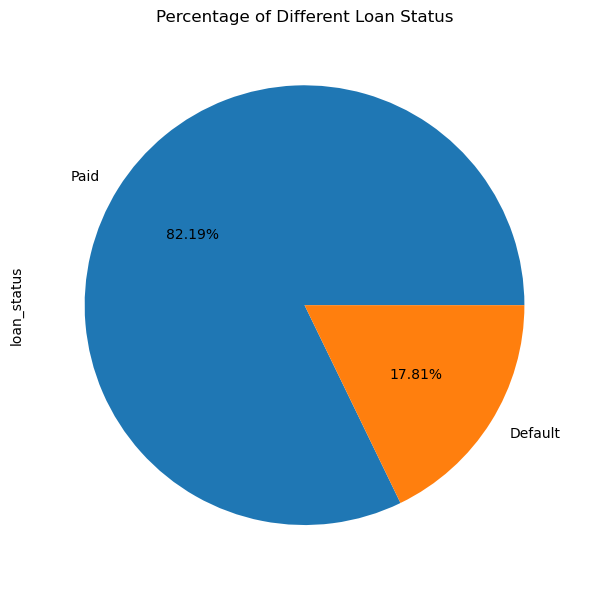

In [12]:
# Create a pie chart for the percentage of each unique value in the modified 'loan_status' column
plt.figure(figsize=(10, 6))
loan_status_counts = df_modified['loan_status'].value_counts()
loan_status_counts.plot(kind='pie', autopct='%1.2f%%')
plt.title('Percentage of Different Loan Status')
plt.tight_layout()
plt.show()

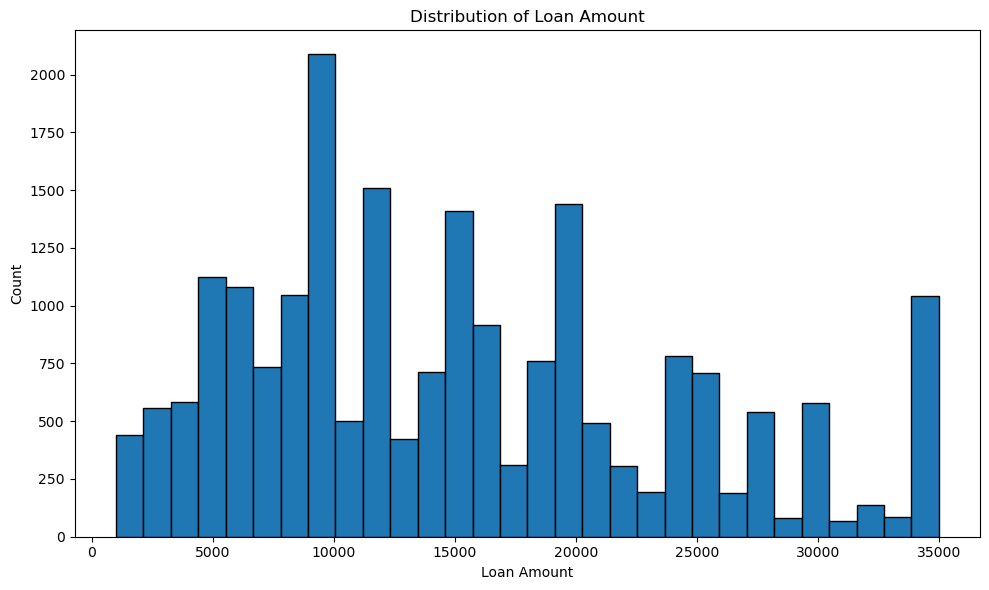

In [13]:
# Plot a histogram for the 'loan_amnt' column
plt.figure(figsize=(10, 6))
plt.hist(df_modified['loan_amnt'], bins=30, edgecolor='black')
plt.xlabel('Loan Amount')
plt.ylabel('Count')
plt.title('Distribution of Loan Amount')
plt.tight_layout()
plt.show()

The histogram shows the distribution of loan amounts in the dataset: 
- Most of the loans are in the range of $5,000 to $20,000.

### Numerical Columns

In [14]:
# Create a list of numerical columns
num_cols = df_modified.select_dtypes(include=np.number).columns.tolist()

# Display the list of numerical columns
num_cols

['loan_amnt',
 'funded_amnt',
 'funded_amnt_inv',
 'int_rate',
 'installment',
 'annual_inc',
 'dti',
 'delinq_2yrs',
 'fico_range_low',
 'fico_range_high',
 'inq_last_6mths',
 'open_acc',
 'pub_rec',
 'revol_bal',
 'revol_util',
 'total_acc',
 'out_prncp',
 'out_prncp_inv',
 'total_pymnt',
 'total_pymnt_inv',
 'total_rec_prncp',
 'total_rec_int',
 'total_rec_late_fee',
 'recoveries',
 'collection_recovery_fee',
 'last_pymnt_amnt',
 'last_fico_range_high',
 'last_fico_range_low',
 'collections_12_mths_ex_med',
 'policy_code',
 'acc_now_delinq',
 'tot_coll_amt',
 'tot_cur_bal',
 'open_acc_6m',
 'open_act_il',
 'open_il_12m',
 'open_il_24m',
 'mths_since_rcnt_il',
 'total_bal_il',
 'il_util',
 'open_rv_12m',
 'open_rv_24m',
 'max_bal_bc',
 'all_util',
 'total_rev_hi_lim',
 'inq_fi',
 'total_cu_tl',
 'inq_last_12m',
 'acc_open_past_24mths',
 'avg_cur_bal',
 'bc_open_to_buy',
 'bc_util',
 'chargeoff_within_12_mths',
 'delinq_amnt',
 'mo_sin_old_il_acct',
 'mo_sin_old_rev_tl_op',
 'mo_sin_r

In [15]:
# Count the number of numerical columns
num_numerical_columns = len(num_cols)

# Display the count
print(f'Number of numerical columns: {num_numerical_columns}')

Number of numerical columns: 83


In [16]:
# Extract the target variable 'y' from the DataFrame 'df_modified'
target_column = 'loan_status'
y = df_modified[target_column]

# Create DataFrame containing only the numerical columns
X_numerical = df_modified[num_cols]

# Split the data into train and test datasets for numerical columns (80% train, 20% test)
X_train_num, X_test_num, y_train, y_test = train_test_split(X_numerical, y, test_size=0.2, random_state=42)

# Reset the index for the train datasets
X_train_num.reset_index(drop=True, inplace=True)
y_train.reset_index(drop=True, inplace=True)

# Reset the index for the test datasets
X_test_num.reset_index(drop=True, inplace=True)
y_test.reset_index(drop=True, inplace=True)

# Initialize SelectKBest with f_classif as the score function to extract top 4 best numerical features
selector_num = SelectKBest(score_func=f_classif, k=50)

# Fit the selector to the training data for numerical columns and transform the training data to get the top 4 features
X_train_num_new = selector_num.fit_transform(X_train_num, y_train)

# Get the indices of the selected features for numerical columns
selected_feature_indices_num = selector_num.get_support(indices=True)

# Get the names of the selected features for numerical columns
selected_features_num = X_train_num.columns[selected_feature_indices_num].tolist()

# Display the selected features in a well-formatted list
print("Selected features:")
for idx, feature in enumerate(selected_features_num, start=1):
    print(f"{idx}. {feature}")

Selected features:
1. loan_amnt
2. funded_amnt
3. funded_amnt_inv
4. int_rate
5. installment
6. annual_inc
7. dti
8. fico_range_low
9. fico_range_high
10. inq_last_6mths
11. out_prncp
12. out_prncp_inv
13. total_pymnt
14. total_pymnt_inv
15. total_rec_prncp
16. total_rec_late_fee
17. recoveries
18. collection_recovery_fee
19. last_pymnt_amnt
20. last_fico_range_high
21. last_fico_range_low
22. tot_cur_bal
23. open_acc_6m
24. open_il_12m
25. open_il_24m
26. mths_since_rcnt_il
27. il_util
28. open_rv_12m
29. open_rv_24m
30. max_bal_bc
31. all_util
32. total_rev_hi_lim
33. inq_fi
34. inq_last_12m
35. acc_open_past_24mths
36. avg_cur_bal
37. bc_open_to_buy
38. bc_util
39. mo_sin_old_rev_tl_op
40. mo_sin_rcnt_rev_tl_op
41. mo_sin_rcnt_tl
42. mort_acc
43. mths_since_recent_bc
44. mths_since_recent_inq
45. num_actv_rev_tl
46. num_rev_tl_bal_gt_0
47. num_tl_op_past_12m
48. percent_bc_gt_75
49. tot_hi_cred_lim
50. total_bc_limit


- Recoveries: post charge off gross recovery
    * "Recoveries" refer to the post-charge off gross recovery amount. In the context of lending or debt collection, a "charge off" occurs when a lender declares a debt as unlikely to be collected and removes it from their books as a loss. After a charge off, the lender may attempt to recover some or all of the debt through various means, such as selling the debt to a collection agency or negotiating a payment plan with the borrower. The amount recovered from the borrower after the charge off is referred to as "Recoveries."
- collection_recovery_fee: post charge off collection fee
    * "Collection Recovery Fee" is the post-charge off collection fee. When a debt is in collections after a charge off, collection agencies or debt collectors may charge a fee for their efforts to collect the outstanding debt from the borrower. This fee is called the "Collection Recovery Fee" and is typically a percentage of the amount collected.
- last_fico_range_high: The upper boundary range the borrower‚ as last FICO pulled belongs to.
- last_fico_range_low: The lower boundary range the borrower‚ as last FICO pulled belongs to.
    * "Last FICO Range High" and "Last FICO Range Low" refer to the upper and lower boundaries, respectively, of the range of the borrower's FICO (Fair Isaac Corporation) credit score at the time of the last FICO score update. The FICO score is a widely used credit scoring model that assesses an individual's creditworthiness based on their credit history and financial behavior. The credit score typically falls within a range, and the FICO score provided by LendingClub (or any other financial institution) is represented as an interval, with the "Last FICO Range High" denoting the upper end of the range and the "Last FICO Range Low" representing the lower end.
    * For example, if a borrower's last FICO score update provided by LendingClub was within a range of 680 to 700, "Last FICO Range High" would be 700, and "Last FICO Range Low" would be 680. These FICO score ranges are used to provide some level of privacy to borrowers while still giving potential lenders or investors an idea of the borrower's creditworthiness.

### Categorical Columns

In [17]:
# Create a list of categorical columns
cat_cols = df_modified.select_dtypes(include='object').columns.tolist()

# Display the list of categorical columns
cat_cols

['term',
 'grade',
 'sub_grade',
 'emp_title',
 'emp_length',
 'home_ownership',
 'verification_status',
 'issue_d',
 'loan_status',
 'pymnt_plan',
 'url',
 'purpose',
 'title',
 'zip_code',
 'addr_state',
 'earliest_cr_line',
 'initial_list_status',
 'last_pymnt_d',
 'last_credit_pull_d',
 'application_type',
 'hardship_flag',
 'disbursement_method',
 'debt_settlement_flag']

In [18]:
# Count the number of numerical columns
num_categorical_columns = len(cat_cols)

# Display the count
print(f'Number of categorical columns: {num_categorical_columns}')

Number of categorical columns: 23


In [19]:
# check number of unique values in each categorical column
df_modified[cat_cols].nunique()

term                        2
grade                       7
sub_grade                  35
emp_title               10863
emp_length                 11
home_ownership              3
verification_status         3
issue_d                     1
loan_status                 2
pymnt_plan                  1
url                     20834
purpose                    12
title                      12
zip_code                  832
addr_state                 49
earliest_cr_line          523
initial_list_status         2
last_pymnt_d               40
last_credit_pull_d         40
application_type            2
hardship_flag               1
disbursement_method         1
debt_settlement_flag        2
dtype: int64

In [20]:
# drop categorical columns with too many unique values
df_modified.drop(columns=['sub_grade', 'emp_title', 'url', 'zip_code', 'addr_state', 'earliest_cr_line', 'last_pymnt_d', 'last_credit_pull_d'], inplace=True)

# display which categorical columns were left
cat_cols_2 = df_modified.select_dtypes(include='object').columns.tolist()
cat_cols_2

['term',
 'grade',
 'emp_length',
 'home_ownership',
 'verification_status',
 'issue_d',
 'loan_status',
 'pymnt_plan',
 'purpose',
 'title',
 'initial_list_status',
 'application_type',
 'hardship_flag',
 'disbursement_method',
 'debt_settlement_flag']

- term: The number of payments on the loan. Values are in months and can be either 36 or 60.
    * The "term" refers to the number of payments on the loan. It is expressed in months and can have two possible values: 36 or 60. This indicates the duration over which the borrower is expected to repay the loan in fixed installments.
- grade: LC assigned loan grade
    * "Grade" refers to the loan grade assigned by LC (LendingClub) or the lending institution. It is used to represent the credit quality of the borrower. Generally, grades are represented by letters (e.g., A, B, C) with A being the highest credit quality and representing lower risk borrowers, while lower grades represent higher risk borrowers.
- emp_length: Employment length in years. Possible values are between 0 and 10 where 0 means less than one year and 10 means ten or more years. 
    * "Employment length" indicates the number of years of employment of the borrower. Possible values range from 0 to 10, where 0 means less than one year of employment, and 10 means ten or more years of employment.
- home_ownership: The home ownership status provided by the borrower during registration. The values are: RENT, OWN, MORTGAGE, OTHER.
    * "Home ownership" represents the home ownership status provided by the borrower during registration. The possible values are RENT, OWN, MORTGAGE, or OTHER, indicating whether the borrower is renting, owning, mortgaging, or has other arrangements related to their residence.
- verification_status: Indicates if income was verified by LC, not verified, or if the income source was verified
    * "Verification status" indicates whether the borrower's income was verified by LC or the lending institution. The possible values are Verified, Not Verified, or Source Verified.
- issue_d: The month which the loan was funded
    * "Issue date" refers to the month in which the loan was funded or issued to the borrower.
- loan_status (target variable): Current status of the loan: Paid, Default.
- pymnt_plan: Indicates if a payment plan has been put in place for the loan
- purpose: A category provided by the borrower for the loan request. 
    * It indicates the reason or intended use of the loan amount.
- title: The loan title provided by the borrower
    * It provides additional information about the purpose of the loan.
- initial_list_status: The initial listing status of the loan. Possible values are: W, F
    * The "initial listing status" indicates whether the loan was initially listed as Whole Loan (W) or Fractional Loan (F) on the lending platform.
- application_type: Indicates whether the loan is an individual application or a joint application with two co-borrowers
- hardship_flag: Indicates whether the borrower is under a hardship plan.
    * A hardship plan, also known as a financial hardship plan, is an arrangement or agreement made between a borrower and a lender to temporarily modify the terms of a loan or debt repayment due to the borrower's financial difficulties. The purpose of a hardship plan is to provide relief to borrowers who are facing financial hardship and are struggling to meet their loan or debt obligations.
- disbursement_method: Represents the method used to disburse the loan amount to the borrower.
- debt_settlement_flag: Indicates whether a debt settlement plan has been put in place for the loan.
    * A debt settlement plan, also known as debt settlement or debt negotiation, is a strategy used by individuals or businesses to settle their outstanding debts with creditors for less than the full amount owed. 
    * In a debt settlement plan, the debtor (the individual or business owing the debt) negotiates with their creditors to reach an agreement on a reduced lump-sum payment or a structured payment plan to settle the debt. This negotiated settlement amount is typically less than the total outstanding debt owed.

In [21]:
# check number of unique values in each categorical column
df_modified[cat_cols_2].nunique()

term                     2
grade                    7
emp_length              11
home_ownership           3
verification_status      3
issue_d                  1
loan_status              2
pymnt_plan               1
purpose                 12
title                   12
initial_list_status      2
application_type         2
hardship_flag            1
disbursement_method      1
debt_settlement_flag     2
dtype: int64

In [22]:
# Get the value counts in each categorical column
for col in cat_cols_2:
    value_counts = df_modified[col].value_counts()
    print(f"Value Counts for {col}:\n{value_counts}\n")

Value Counts for term:
 36 months    14416
 60 months     6418
Name: term, dtype: int64

Value Counts for grade:
B    6338
C    6096
A    3659
D    2827
E    1419
F     409
G      86
Name: grade, dtype: int64

Value Counts for emp_length:
10+ years    7328
< 1 year     2049
2 years      1944
3 years      1795
1 year       1434
5 years      1383
4 years      1263
8 years      1143
6 years       905
9 years       803
7 years       787
Name: emp_length, dtype: int64

Value Counts for home_ownership:
MORTGAGE    10289
RENT         8260
OWN          2285
Name: home_ownership, dtype: int64

Value Counts for verification_status:
Source Verified    8600
Not Verified       6323
Verified           5911
Name: verification_status, dtype: int64

Value Counts for issue_d:
Dec-2015    20834
Name: issue_d, dtype: int64

Value Counts for loan_status:
Paid       17123
Default     3711
Name: loan_status, dtype: int64

Value Counts for pymnt_plan:
n    20834
Name: pymnt_plan, dtype: int64

Value Counts fo

In [23]:
# Shows the distribution of the features in the dataset
df_modified.select_dtypes('object')

,term,grade,emp_length,home_ownership,verification_status,issue_d,loan_status,pymnt_plan,purpose,title,initial_list_status,application_type,hardship_flag,disbursement_method,debt_settlement_flag
0,36 months,C,10+ years,MORTGAGE,Not Verified,Dec-2015,Paid,n,debt_consolidation,Debt consolidation,w,Individual,N,Cash,N
1,36 months,C,10+ years,MORTGAGE,Not Verified,Dec-2015,Paid,n,small_business,Business,w,Individual,N,Cash,N
3,60 months,C,10+ years,MORTGAGE,Source Verified,Dec-2015,Paid,n,debt_consolidation,Debt consolidation,w,Individual,N,Cash,N
4,60 months,F,3 years,MORTGAGE,Source Verified,Dec-2015,Paid,n,major_purchase,Major purchase,w,Individual,N,Cash,N
5,36 months,C,4 years,RENT,Source Verified,Dec-2015,Paid,n,debt_consolidation,Debt consolidation,w,Individual,N,Cash,N
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22503,60 months,C,< 1 year,OWN,Source Verified,Dec-2015,Paid,n,credit_card,Credit card refinancing,f,Individual,N,Cash,N
22505,60 months,E,10+ years,MORTGAGE,Verified,Dec-2015,Paid,n,debt_consolidation,Debt consolidation,w,Individual,N,Cash,N
22506,60 months,C,< 1 year,RENT,Verified,Dec-2015,Default,n,debt_consolidation,Debt consolidation,w,Individual,N,Cash,N
22508,60 months,D,1 year,RENT,Verified,Dec-2015,Default,n,debt_consolidation,Debt consolidation,w,Individual,N,Cash,N


In [24]:
# Set display options to show all columns and rows
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [25]:
# Instantiate the OneHotEncoder
ohe = OneHotEncoder()

# Identify the categorical columns (excluding the target variable)
categorical_cols = df_modified.select_dtypes(include='object').drop(columns=['loan_status']).columns.tolist()

# Perform one-hot encoding using OneHotEncoder
encoded_features = ohe.fit_transform(df_modified[categorical_cols])

# Create a new dataframe with the encoded features
df_encoded = pd.DataFrame(encoded_features.toarray(), columns=ohe.get_feature_names_out(), dtype=int)

# Inspect the encoding results
df_encoded.isna().sum()

term_ 36 months                        0
term_ 60 months                        0
grade_A                                0
grade_B                                0
grade_C                                0
grade_D                                0
grade_E                                0
grade_F                                0
grade_G                                0
emp_length_1 year                      0
emp_length_10+ years                   0
emp_length_2 years                     0
emp_length_3 years                     0
emp_length_4 years                     0
emp_length_5 years                     0
emp_length_6 years                     0
emp_length_7 years                     0
emp_length_8 years                     0
emp_length_9 years                     0
emp_length_< 1 year                    0
home_ownership_MORTGAGE                0
home_ownership_OWN                     0
home_ownership_RENT                    0
verification_status_Not Verified       0
verification_sta

In [26]:
# Extract the target variable 'y' from the DataFrame 'df_modified'
target_column = 'loan_status'
y = df_modified[target_column]

# Split the data into train and test datasets for the one-hot encoded categorical columns (80% train, 20% test)
X_train_cat, X_test_cat, y_train, y_test = train_test_split(df_encoded, y, test_size=0.2, random_state=42)

# Reset the index of the train datasets
X_train_cat.reset_index(drop=True, inplace=True)
y_train.reset_index(drop=True, inplace=True)

# Reset the index of the test datasets
X_test_cat.reset_index(drop=True, inplace=True)
y_test.reset_index(drop=True, inplace=True)

# Initialize SelectKBest with chi2 as the score function to extract top 4 best categorical features
selector_cat = SelectKBest(score_func=chi2, k=4)

# Fit the selector to the training data for categorical columns and transform the training data to get the top 4 features
X_train_cat_new = selector_cat.fit_transform(X_train_cat, y_train)

# Get the indices of the selected features for categorical columns
selected_feature_indices_cat = selector_cat.get_support(indices=True)

# Get the names of the selected features for categorical columns
selected_features_cat = X_train_cat.columns[selected_feature_indices_cat].tolist()

# Display the selected categorical features
print("Selected categorical features:")
for idx, feature in enumerate(selected_features_cat, start=1):
    print(f"{idx}. {feature}")

Selected categorical features:
1. grade_A
2. grade_D
3. grade_E
4. debt_settlement_flag_Y


## Combination of Features

### Train Data

In [27]:
# Check the distribution of the numerical features
X_train_num[selected_features_num].shape

(16667, 50)

In [28]:
# Check the distribution of the categorical features
X_train_cat[selected_features_cat].shape

(16667, 4)

In [29]:
# Check if the indices of X_train_num and X_train_cat are identical
indices_equal = (X_train_num.index == X_train_cat.index).all()

print("Are the indices identical?", indices_equal)

Are the indices identical? True


In [30]:
# Concatenate the DataFrames
X_train_final = pd.concat([X_train_num[selected_features_num], X_train_cat[selected_features_cat], y_train], axis=1)

# Display the final train dataset
X_train_final.head()

,loan_amnt,funded_amnt,funded_amnt_inv,int_rate,installment,annual_inc,dti,fico_range_low,fico_range_high,inq_last_6mths,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_amnt,last_fico_range_high,last_fico_range_low,tot_cur_bal,open_acc_6m,open_il_12m,open_il_24m,mths_since_rcnt_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,inq_last_12m,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_inq,num_actv_rev_tl,num_rev_tl_bal_gt_0,num_tl_op_past_12m,percent_bc_gt_75,tot_hi_cred_lim,total_bc_limit,grade_A,grade_D,grade_E,debt_settlement_flag_Y,loan_status
0,35000.0,35000.0,35000.0,13.67,1190.62,225000.0,33.53,700.0,704.0,1.0,0.0,0.0,14647.190000,14647.19,8337.65,0.0,2767.57,498.1626,1190.62,614.0,610.0,762419.0,1.0,2.0,2.0,5.000000,20.000000,0.0,1.0,14720.0,52.0,273500.0,0.0,2.0,3.0,76242.0,6039.0,71.9,282.0,16.0,5.0,3.0,16.0,5.000000,3.0,4.0,2.0,50.0,888059.0,21500.0,0,0,0,0,Default
1,2500.0,2500.0,2500.0,17.86,90.21,8400.0,5.57,705.0,709.0,0.0,0.0,0.0,2064.430000,2064.43,1295.41,0.0,172.50,31.0500,90.21,544.0,540.0,600.0,1.0,0.0,0.0,20.917873,71.576499,1.0,1.0,0.0,4.0,16500.0,1.0,1.0,1.0,200.0,15000.0,0.0,170.0,3.0,3.0,0.0,170.0,9.000000,2.0,2.0,1.0,0.0,16500.0,15000.0,0,1,0,0,Default
2,3500.0,3500.0,3500.0,10.64,113.99,43420.0,17.25,785.0,789.0,0.0,0.0,0.0,4101.559104,4101.56,3500.00,0.0,0.00,0.0000,113.98,724.0,720.0,21736.0,1.0,1.0,2.0,6.000000,86.000000,0.0,0.0,1520.0,46.0,24500.0,0.0,0.0,2.0,3623.0,12086.0,14.3,223.0,38.0,6.0,0.0,38.0,6.458108,3.0,3.0,1.0,0.0,46850.0,14100.0,0,0,0,0,Paid
3,13450.0,13450.0,13450.0,12.59,450.54,60000.0,8.52,715.0,719.0,1.0,0.0,0.0,13803.610000,13803.61,13450.00,0.0,0.00,0.0000,12962.50,754.0,750.0,10985.0,2.0,2.0,3.0,3.000000,98.000000,1.0,1.0,909.0,45.0,14700.0,1.0,2.0,4.0,1569.0,13560.0,7.8,44.0,5.0,3.0,0.0,5.0,5.000000,4.0,4.0,3.0,16.7,24700.0,14700.0,0,0,0,0,Paid
4,15000.0,15000.0,15000.0,18.49,384.92,70000.0,22.54,675.0,679.0,1.0,0.0,0.0,21586.158155,21586.16,15000.00,0.0,0.00,0.0000,8140.73,699.0,695.0,185245.0,3.0,2.0,3.0,6.000000,83.000000,2.0,2.0,4544.0,65.0,15800.0,3.0,9.0,6.0,23156.0,7212.0,49.6,79.0,1.0,1.0,1.0,1.0,4.000000,3.0,3.0,5.0,50.0,200660.0,14300.0,0,0,1,0,Paid


In [31]:
# Display the shape of the training data
X_train_final.shape

(16667, 55)

In [32]:
# Check for missing values in the dataframe
X_train_final.isna().sum()

loan_amnt                  0
funded_amnt                0
funded_amnt_inv            0
int_rate                   0
installment                0
annual_inc                 0
dti                        0
fico_range_low             0
fico_range_high            0
inq_last_6mths             0
out_prncp                  0
out_prncp_inv              0
total_pymnt                0
total_pymnt_inv            0
total_rec_prncp            0
total_rec_late_fee         0
recoveries                 0
collection_recovery_fee    0
last_pymnt_amnt            0
last_fico_range_high       0
last_fico_range_low        0
tot_cur_bal                0
open_acc_6m                0
open_il_12m                0
open_il_24m                0
mths_since_rcnt_il         0
il_util                    0
open_rv_12m                0
open_rv_24m                0
max_bal_bc                 0
all_util                   0
total_rev_hi_lim           0
inq_fi                     0
inq_last_12m               0
acc_open_past_

### Test Data

In [33]:
# Check the distribution of the numerical features
X_test_num[selected_features_num].shape

(4167, 50)

In [34]:
# Check the distribution of the categorical features
X_test_cat[selected_features_cat].shape

(4167, 4)

In [35]:
# Check if the indices of X_test_num and X_test_cat are identical
indices_equal = (X_test_num.index == X_test_cat.index).all()

print("Are the indices identical?", indices_equal)

Are the indices identical? True


In [36]:
# Concatenate the DataFrames
X_test_final = pd.concat([X_test_num[selected_features_num], X_test_cat[selected_features_cat], y_test], axis=1)

# Display the final test dataset
X_test_final.head()

,loan_amnt,funded_amnt,funded_amnt_inv,int_rate,installment,annual_inc,dti,fico_range_low,fico_range_high,inq_last_6mths,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_amnt,last_fico_range_high,last_fico_range_low,tot_cur_bal,open_acc_6m,open_il_12m,open_il_24m,mths_since_rcnt_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,inq_last_12m,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_inq,num_actv_rev_tl,num_rev_tl_bal_gt_0,num_tl_op_past_12m,percent_bc_gt_75,tot_hi_cred_lim,total_bc_limit,grade_A,grade_D,grade_E,debt_settlement_flag_Y,loan_status
0,27000.0,27000.0,27000.0,10.78,584.09,58000.0,14.19,685.0,689.0,0.0,0.00,0.00,14796.970000,14796.97,7854.84,0.00,2571.50,462.8700,584.09,574.0,570.0,150397.0,0.0,0.0,0.0,36.0,91.0,1.0,2.0,2604.0,80.0,20100.0,1.0,5.0,3.0,10026.0,3696.0,41.3,227.0,12.0,12.0,3.0,134.0,1.0,5.0,5.0,1.0,0.0,164566.0,6300.0,0,0,0,0,Default
1,18000.0,18000.0,18000.0,19.89,475.79,50000.0,13.49,665.0,669.0,3.0,8711.44,8711.44,18030.300000,18030.30,9288.56,0.00,0.00,0.0000,475.79,689.0,685.0,11014.0,1.0,0.0,0.0,33.0,8.0,1.0,3.0,9874.0,44.0,16200.0,0.0,3.0,3.0,1836.0,3142.0,76.6,194.0,2.0,2.0,0.0,23.0,1.0,2.0,2.0,1.0,66.7,25280.0,13400.0,0,0,1,0,Paid
2,2000.0,2000.0,2000.0,11.48,65.94,115000.0,24.64,665.0,669.0,1.0,0.00,0.00,439.060000,439.06,189.93,0.00,176.58,31.7844,65.94,539.0,535.0,88817.0,2.0,3.0,5.0,2.0,86.0,1.0,4.0,22245.0,70.0,66200.0,2.0,2.0,9.0,4037.0,1764.0,84.5,290.0,7.0,2.0,1.0,7.0,2.0,15.0,17.0,4.0,66.7,117730.0,35000.0,0,0,0,0,Default
3,30000.0,30000.0,29800.0,16.55,738.34,110000.0,31.78,685.0,689.0,2.0,0.00,0.00,20691.870000,20553.92,6564.07,36.92,7420.00,1335.6000,738.34,579.0,575.0,124110.0,1.0,1.0,3.0,11.0,86.0,2.0,9.0,6499.0,61.0,58900.0,1.0,5.0,12.0,6895.0,27654.0,41.5,140.0,1.0,1.0,0.0,1.0,3.0,8.0,8.0,3.0,30.0,183642.0,47300.0,0,1,0,1,Default
4,15000.0,15000.0,15000.0,9.76,482.32,65000.0,9.49,730.0,734.0,1.0,0.00,0.00,17355.364586,17355.36,15000.00,0.00,0.00,0.0000,482.29,714.0,710.0,13398.0,1.0,1.0,1.0,12.0,75.0,1.0,2.0,2354.0,36.0,25900.0,0.0,2.0,3.0,1675.0,14836.0,20.7,60.0,1.0,1.0,0.0,23.0,1.0,4.0,4.0,2.0,0.0,36900.0,18700.0,0,0,0,0,Paid


In [37]:
# Display the shape of the testing data
X_test_final.shape

(4167, 55)

In [38]:
# Check for missing values in the dataframe
X_test_final.isna().sum()

loan_amnt                  0
funded_amnt                0
funded_amnt_inv            0
int_rate                   0
installment                0
annual_inc                 0
dti                        0
fico_range_low             0
fico_range_high            0
inq_last_6mths             0
out_prncp                  0
out_prncp_inv              0
total_pymnt                0
total_pymnt_inv            0
total_rec_prncp            0
total_rec_late_fee         0
recoveries                 0
collection_recovery_fee    0
last_pymnt_amnt            0
last_fico_range_high       0
last_fico_range_low        0
tot_cur_bal                0
open_acc_6m                0
open_il_12m                0
open_il_24m                0
mths_since_rcnt_il         0
il_util                    0
open_rv_12m                0
open_rv_24m                0
max_bal_bc                 0
all_util                   0
total_rev_hi_lim           0
inq_fi                     0
inq_last_12m               0
acc_open_past_

### Save the Datasets

In [ ]:
# Save the final train and test datasets to Parquet format
X_train_final.to_parquet('dataset/train_dataset.parquet', index=False)
X_test_final.to_parquet('dataset/test_dataset.parquet', index=False)